# MCMC sampler to approximate a distribution

In [92]:
import os
import sys
import glob

import numpy as np
from scipy.stats import norm
from scipy.stats import beta
import pandas as pd

from functools import partial
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MultipleLocator
import seaborn as sns

%matplotlib inline
%precision 4
plt.style.use('ggplot')
plt.figure(figsize=(12, 9))

sns.set_style('white')
sns.set_context('talk')

<Figure size 864x648 with 0 Axes>

## Utilities

In [93]:
def plot_likelihood(current, proposal, mu_current, mu_proposal, sigma, acceptance, trace, data, target):
    color = 'g' if acceptance else 'r' 

    x = np.linspace(
        TARGET_MEAN - TARGET_SIGMA * 10, 
        TARGET_MEAN + TARGET_SIGMA * 10, 
        100
    )
    y = norm(loc=mu_proposal, scale=sigma).pdf(x)
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

    sns.distplot(data, kde=True, norm_hist=True, ax=ax1, color='lightblue')
 
    ax1.plot(x, y, color=color)
    ax1.axvline(mu_current, color='b', linestyle='--', label='mu_current')
    ax1.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
    ax1.set(
        title='likelihood(mu=%.2f) = %.2f\nproposal likelihood(mu=%.2f) = %.2f' % 
        (mu_current, current, mu_proposal, proposal)
    )
    
    ax2.plot(trace, color='k')
    ax2.set_ylim(0, 50)
    ax2.set_ylim(target - 5 * np.abs(sigma), target + 5 * np.abs(sigma))
    ax2.axhline(y=target, color='b', linestyle='--', label="target")
    ax2.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()
    plt.legend()

    spacing = 0.2
    minorLocator = MultipleLocator(spacing)
    ax2.yaxis.set_minor_locator(minorLocator)
    #ax2.xaxis.set_minor_locator(minorLocator)    
    
    ax2.grid(
        which='major', 
        color='k',
        linestyle='--',
        linewidth=0.2
    )
    ax2.grid(
        which='minor', 
        color='k',
        alpha=0.5,
        linewidth=0.2
    )

In [94]:
def plot_trace(trace, target, sigma, ax):

    sns.distplot(data, kde=True, norm_hist=True, ax=ax, color='lightblue')
 
    ax.plot(trace, color='k')
    ax.set_ylim(0, 50)
    ax.set_ylim(target - 2 * np.abs(sigma), target + 2 * np.abs(sigma))
    ax.axhline(y=target, color='b', linestyle='--', label="target")
    ax.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()
    plt.legend()

    spacing = 0.5
    minorLocator = MultipleLocator(spacing)
    ax.yaxis.set_minor_locator(minorLocator)
    #ax2.xaxis.set_minor_locator(minorLocator)    
    
    ax.grid(
        which='major', 
        color='k',
        linestyle='--',
        linewidth=0.2
    )
    ax.grid(
        which='minor', 
        color='k',
        alpha=0.5,
        linewidth=0.2
    )

# MCMC Sampler
Approximate a target probability distribution with a MCMC sampler.

## Prior distribution
Define prior distribution function

In [95]:
def prior(mean, sigma, theta):
    # To match with log(posterior)
    _prior = np.log(norm(mean, sigma).pdf(theta))
    #print ("priori is {0}".format(_prior))
    #return _prior
    return 1

## Posterior function

In [96]:
# Likelihood
def __likelihood(mean, sigma, data):
    return np.sum(-np.log(sigma * np.sqrt(2* np.pi) )-((data-mean)**2) / (2*sigma**2))

def likelihood(mean, sigma, data):
    return np.sum(-0.5 * np.log(2*np.pi) - np.log(sigma) - ((data-mean)**2) / (2*sigma**2) )

# Posterior
def posterior(likelihood, prior):
    return likelihood * prior

## Acceptance
Propose a next position based on the current position in the Markov Chain and run the acceptance. 

In [97]:
# proposal
def proposal(current, sigma):
    return norm(current, sigma).rvs()

# Acceptance
def accept(current, proposed):
    """
    Args:
        current: log(posterior(current-theta))
        proposed: log(posterior(proposed-theta))
    """
    # Since using log(posterior/posterior) -> log(posterior) - log(posterior)
    # To compare with u, need to rever back with exp.
    r = np.exp(proposed - current)
    u = np.random.uniform()
    """
    print("Rate is {0} u is {1}".format(
        np.exp(proposed - current),
        u
    ))
"""
    if min(1, r) > u: 
        #print("ACCEPT!")
        return True
    else:
        return False

# Execution

In [98]:
PROPOSAL_MEAN_DEFAULT=1
PROPOSAL_SIGMA_DEFAULT = 10.0
DEFAULT_ITERATION=1000

def mcmc(
    data=np.array([]), 
    mean=PROPOSAL_MEAN_DEFAULT, 
    sigma=PROPOSAL_SIGMA_DEFAULT, 
    iterations=DEFAULT_ITERATION, 
    target=PROPOSAL_MEAN_DEFAULT,
    flag_plot=True
):
    """
    Args:
        data: Observed data
        mean: Initial mean of the proposal distribution (prior)
        sigma: Initial variance of the proposal distribution (prior)
        iterations: number of samples to take
        target: The mean of the target distribution to estimate. Only to show if the MCMC is approaching it
    """
    accepted = []
    rejected = []
    trace = []
    
    current = mean
    for i in range(iterations):
        previous = current

        candidate = proposal(current, sigma)    
        acceptance = accept(
            # log(likelihood * prior) -> log(likelihood) + log(prior)
#            likelihood(current, sigma, data) + prior(current, sigma, current),      
#            likelihood(candidate, sigma, data) + prior(candidate, sigma, candidate)
            likelihood(current, sigma, data),
            likelihood(candidate, sigma, data)
        )

        if acceptance is True:
            accepted.append(candidate)
            current = candidate
        else:
            rejected.append(candidate)
                
        trace.append(current)

        if flag_plot:
            plot_likelihood(
                likelihood(previous, sigma, data),
                likelihood(candidate, sigma, data),
                previous, 
                candidate, 
                sigma,
                acceptance,
                trace,
                data, 
                target
            )

    return np.array(accepted), np.array(rejected), np.array(trace)

## Generate the target distribution
Generate a distribution to approximate with MCMC.

mean is 3.1442172369615444
variance is 0.9939992925526802


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


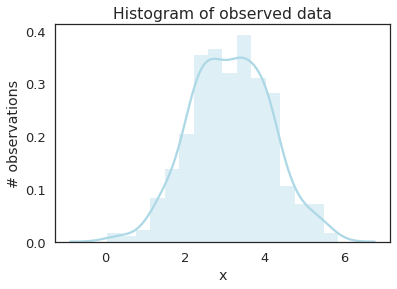

In [99]:
thetas = np.linspace(0, 1, 200)
MEAN = 3.14151987
SIGMA= 3

data = np.random.randn(500) + MEAN
#data = np.random.normal(MEAN, SIGMA, 5000)
TARGET_MEAN = np.mean(data)
TARGET_SIGMA = np.var(data)


ax = plt.subplot()
sns.distplot(data, kde=True, ax=ax, color='lightblue')
_ = ax.set(title='Histogram of observed data', xlabel='x', ylabel='# observations');

print("mean is {0}".format(TARGET_MEAN))
print("variance is {0}".format(TARGET_SIGMA))

## Run MCMC sampler

In [100]:
initial_prior_mean = 2          # Randomly choosing
initial_prior_variance = TARGET_SIGMA * 10
iterations = 100000
flag_plot=False

accepted, rejected, trace = mcmc(
    data,
    initial_prior_mean, 
    initial_prior_variance,
    iterations, 
    TARGET_MEAN,
    flag_plot
)  

## Plot MCMC random walk

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


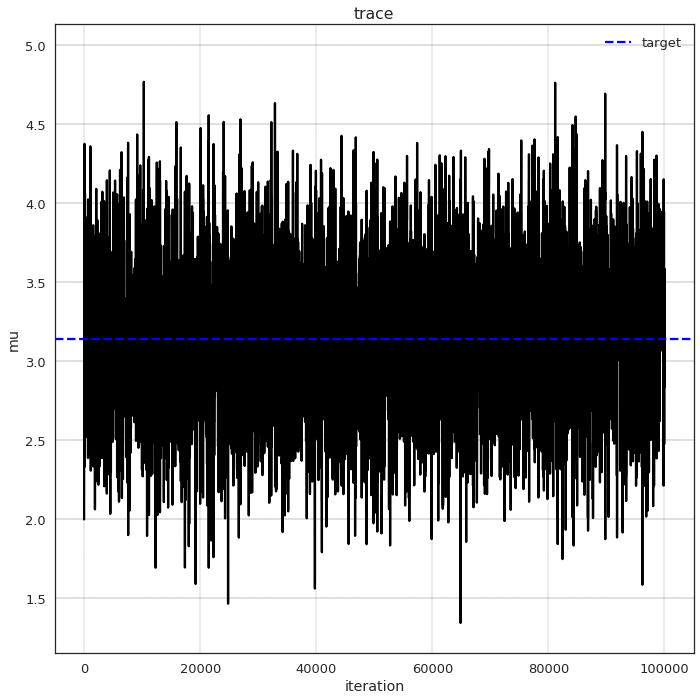

In [101]:
fig, ax = plt.subplots(ncols=1, figsize=(10, 10))
plot_trace(trace, TARGET_MEAN, TARGET_SIGMA, ax)

## Display approximated distribution

(array([2.8000e+01, 4.9700e+02, 3.0850e+03, 1.2744e+04, 2.4555e+04,
        3.0366e+04, 1.9947e+04, 7.2280e+03, 1.4490e+03, 1.0100e+02]),
 array([1.3446, 1.687 , 2.0295, 2.372 , 2.7144, 3.0569, 3.3994, 3.7418,
        4.0843, 4.4268, 4.7693]),
 <a list of 10 Patch objects>)

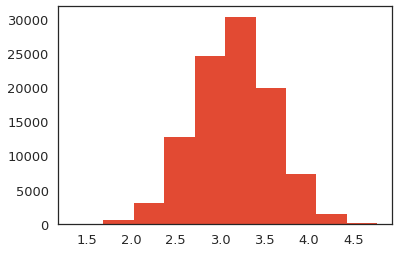

In [102]:
plt.hist(trace)